## Introduction

This notebook define a U-net segmentation model as described in the book "Hands on Neural Network with Tensorflow 2" (chapter 8), and its training / evaluation procedures.
The book proposes a (very) simplified version of the orginal U-net architecture, and do not use pre-trained model basis.
In consequence, the model is trained from scratch and should produce relatively bad performances.
The main objectives here are not the model performances but to study the model architecture, proposing an architecture that produces an output with the same resolution as the input, working on training from scratch.

I introduced some small improvements in the model definition by adding regularisations and batch normalisation, and also in the training procedure by adding a learning rate callback.

## Disclaimer

This notebook is shared for study purposes and the model produced with the following code should not be used for real applications.
The model definition does not use a pretrained basis, so the training is done from scratch by using a small dataset. This dataset does not provide enough information to train a model with good performances.

## Important notes

As the code proposed in the book, to develop a model for semantic segmentation using the VOC2007 dataset, is not compatible with the current versions of the libraries, I will propose a new code to develop a model for semantic segmentation using the Oxford-IIT Pet Dataset.


In [1]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.11/dist-packages/tensorflow-2.17.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.1


In [2]:
!pip install -q tensorflow_datasets==4.8.0
!pip install -q -U tensorflow-text tensorflow==2.15
!pip install protobuf==3.20.*

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.71 requires ml_dtypes>=0.3.1

In [1]:
import numpy as np

import tensorflow as tf
print(tf.__version__)


2.15.0


In [2]:
import tensorflow_datasets as tfds
import math
import os

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive

# mounting my google drive
drive.mount("/content/gdrive", force_remount=True)
models_path = "/content/gdrive/My Drive/models/"

Mounted at /content/gdrive


In [5]:
def downsample(depth):
    return tf.keras.Sequential(
        [
            # Adding regularisation to the layer to reduce overfitting
            tf.keras.layers.Conv2D(
                depth, 3, strides=2, padding="same", kernel_initializer="he_normal",
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
                bias_regularizer=tf.keras.regularizers.l2(0.01)
            ),
            # Adding batch normalisation for training speed up and overfitting reduction
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
        ]
    )


def upsample(depth):
    return tf.keras.Sequential(
        [
            # Adding regularisation to the layer to reduce overfitting
            tf.keras.layers.Conv2DTranspose(
                depth, 3, strides=2, padding="same", kernel_initializer="he_normal",
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
                bias_regularizer=tf.keras.regularizers.l2(0.01)
            ),
            # Adding batch normalisation for training speed up and overfitting reduction
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
        ]
    )

In [6]:
def get_unet(input_size=(256, 256, 3), num_classes=21):

    # Downsample from 256x256 to 4x4, while adding depth
    # using powers of 2, startin from 2**5. Cap to 512.
    size=input_size[0]
    encoders = []
    for i in range(2, int(math.log2(size))):
        depth = 2 ** (i + 5)
        if depth > 512:
            depth = 512
        encoders.append(downsample(depth=depth))

    # Upsample from 4x4 to 256x256, reducing the depth
    decoders = []
    for i in reversed(range(2, int(math.log2(size)))):
        depth = 2 ** (i + 5)
        print("i = {}, depth = {}".format(i, depth))
        if depth < 32:
            depth = 32
        if depth > 512:
            depth = 512
        decoders.append(upsample(depth=depth))

    # Build the model by invoking the encoder layers with the correct input
    inputs = tf.keras.layers.Input(input_size)
    concat = tf.keras.layers.Concatenate()

    x = inputs
    # Encoder: downsample loop
    skips = []
    for conv in encoders:
        x = conv(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Decoder: input + skip connection
    for deconv, skip in zip(decoders, skips):
        x = deconv(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Add the last layer on top and define the model
    last = tf.keras.layers.Conv2DTranspose(
        num_classes, 3, strides=2, padding="same", kernel_initializer="he_normal",
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )

    outputs = last(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


## Downloading the Oxford-IIIT Pets dataset

The dataset is available from TensorFlow Datasets. The segmentation masks are included in version 3+.

In [8]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In addition, the image color values are normalized to the [0, 1] range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [9]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [10]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits:

In [11]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [12]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image. Go to the Image augmentation tutorial to learn more.

In [13]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

In [14]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [15]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

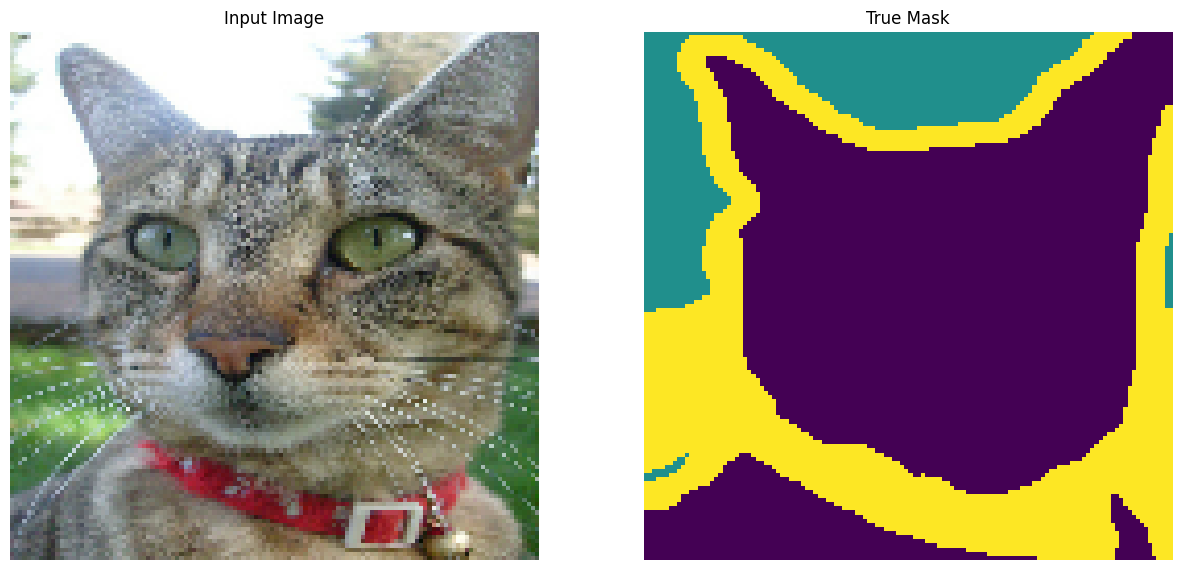

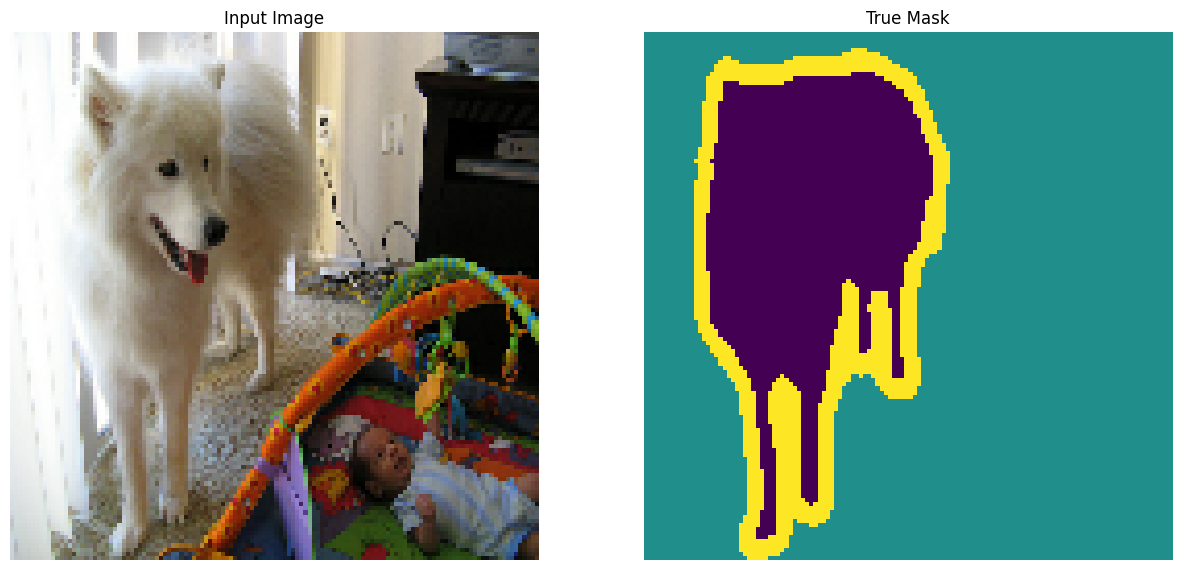

In [16]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [23]:
OUTPUT_CLASSES = 3
model = get_unet(input_size=(128,128,3), num_classes=OUTPUT_CLASSES)

optimizer = tf.optimizers.Adam()

checkpoint_path = "ckpt/checkpoint.model.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
            monitor = "val_accuracy",
            mode = "auto",
            save_freq="epoch")
tensorboard = tf.keras.callbacks.TensorBoard(write_images=True)
model.compile(optimizer=optimizer,
              #loss=lambda y_true, y_pred: tf.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred) + tf.losses.MeanAbsoluteError()(y_true, y_pred),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])#, tf.metrics.MeanIoU(num_classes=21)])

i = 6, depth = 2048
i = 5, depth = 1024
i = 4, depth = 512
i = 3, depth = 256
i = 2, depth = 128


Try out the model to check what it predicts before training:

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 360ms/step


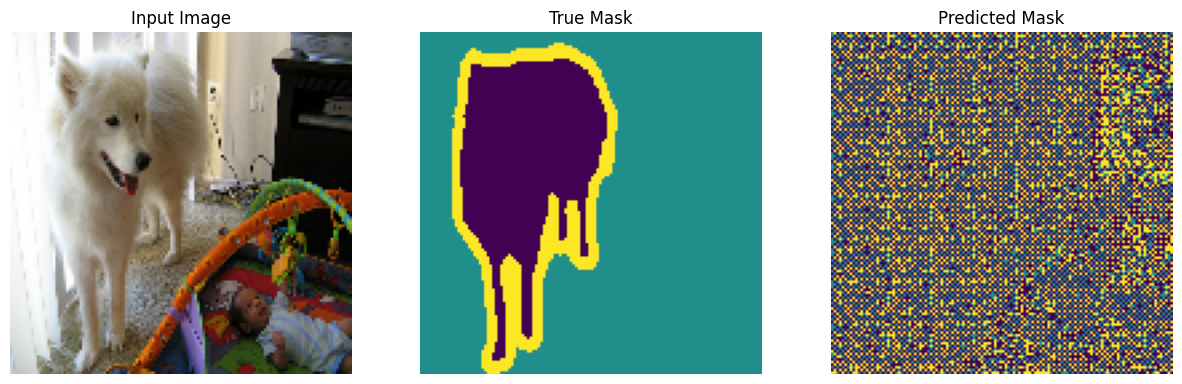

In [24]:
show_predictions()

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 34ms/step


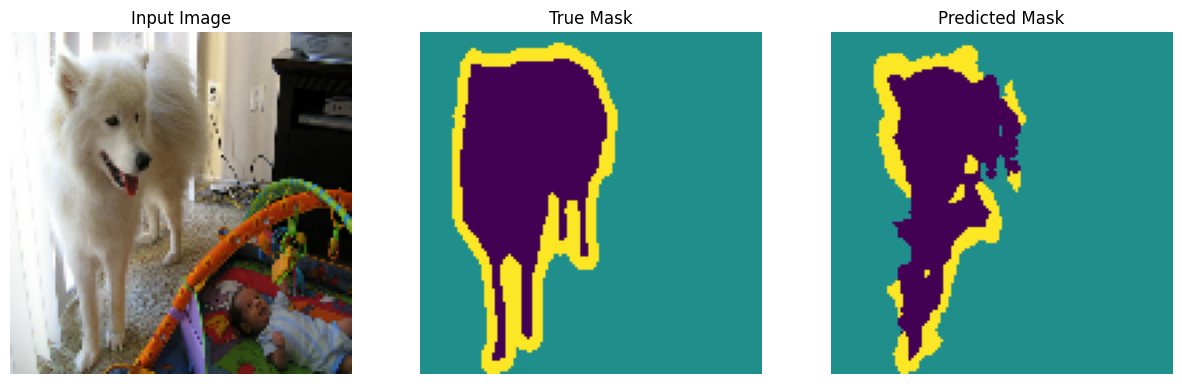


Sample Prediction after epoch 100

57/57 [==============================] - 39s 679ms/step - loss: 0.3222 - accuracy: 0.9211 - val_loss: 0.5051 - val_accuracy: 0.8615 - lr: 1.0000e-06


In [26]:
EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10)

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(), cp_callback, reduce_lr])

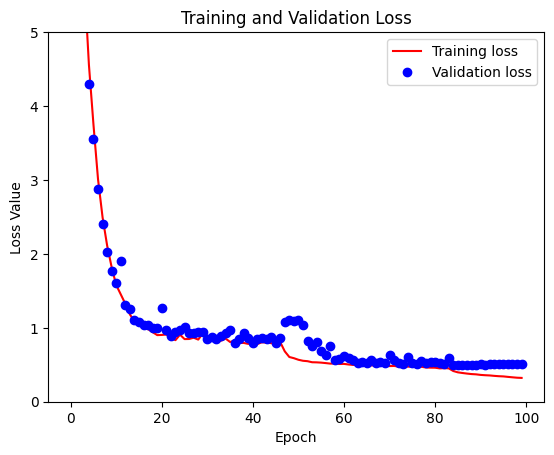

In [30]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 5])
plt.legend()
plt.show()
# The following figure is the training history for the 1st run, a second training run has been accidentally launched without changing hyper-params

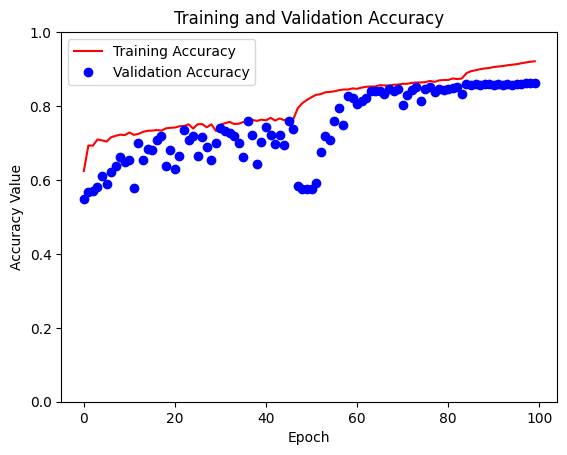

In [32]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']


plt.figure()
plt.plot(model_history.epoch, accuracy, 'r', label='Training Accuracy')
plt.plot(model_history.epoch, val_accuracy, 'bo', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [33]:
# saving the model
model.save(os.path.join(models_path,"segmentation_pets.h5"),save_format="h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

2/2 [==============================] - 0s 141ms/step


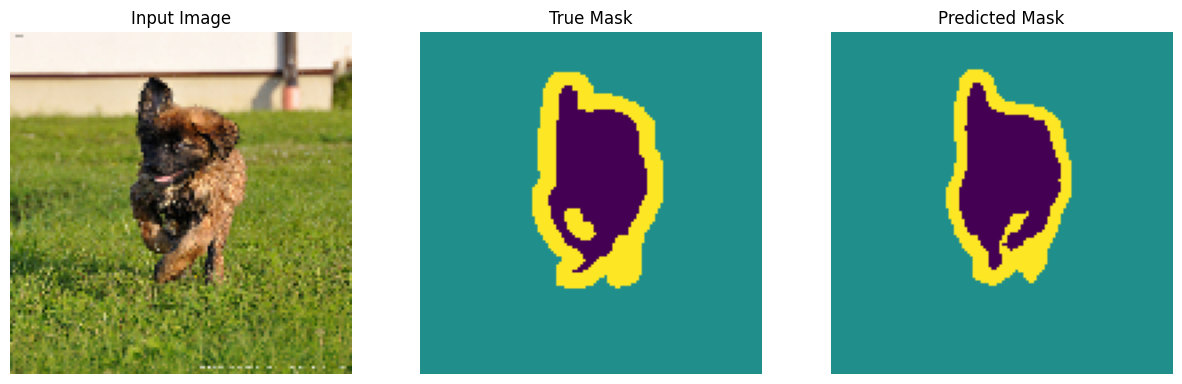

2/2 [==============================] - 0s 86ms/step


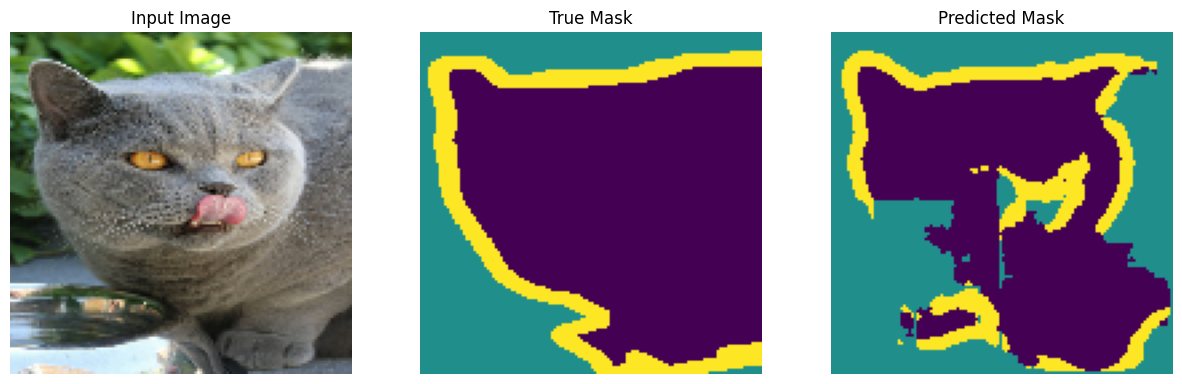

2/2 [==============================] - 0s 102ms/step


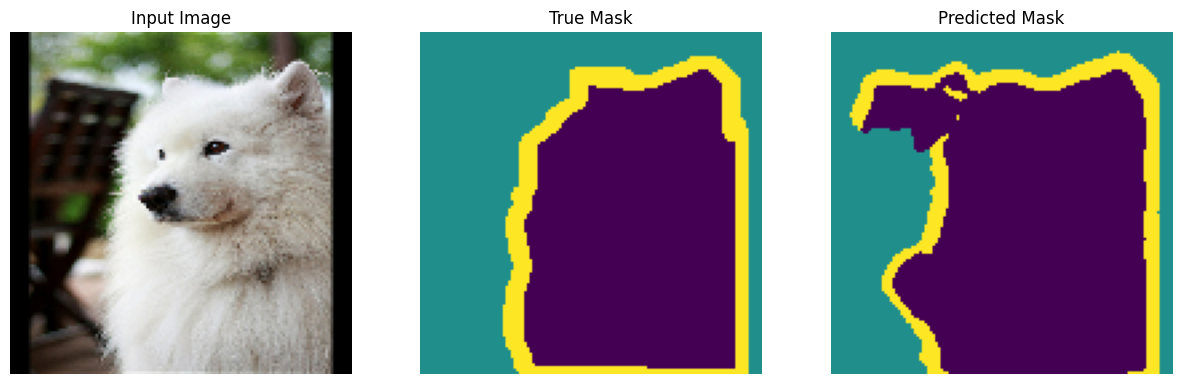

2/2 [==============================] - 0s 89ms/step


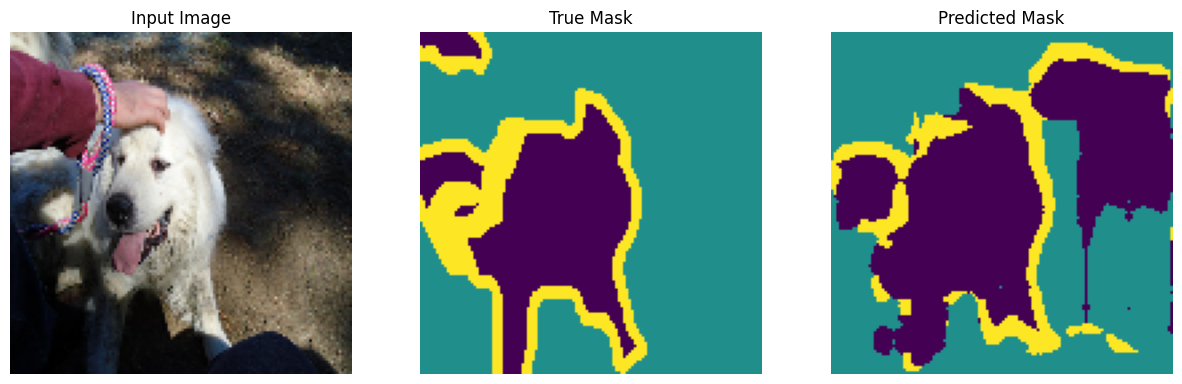

2/2 [==============================] - 0s 89ms/step


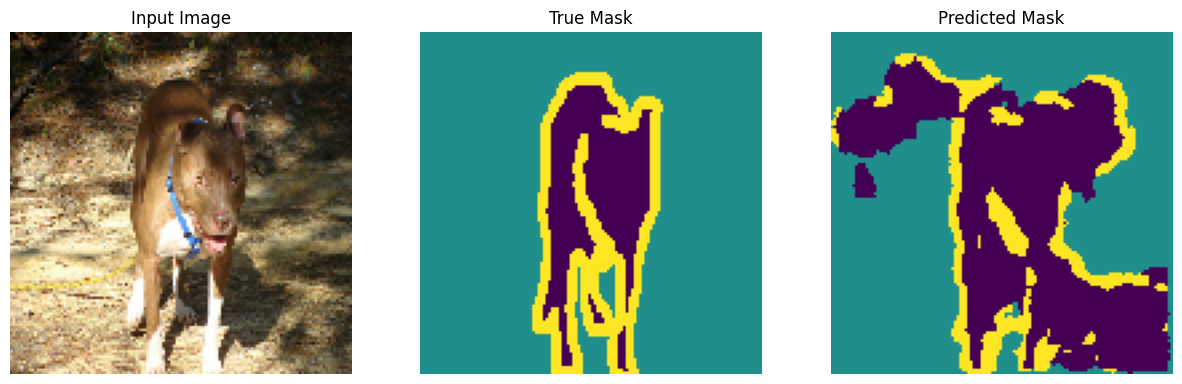

2/2 [==============================] - 0s 87ms/step


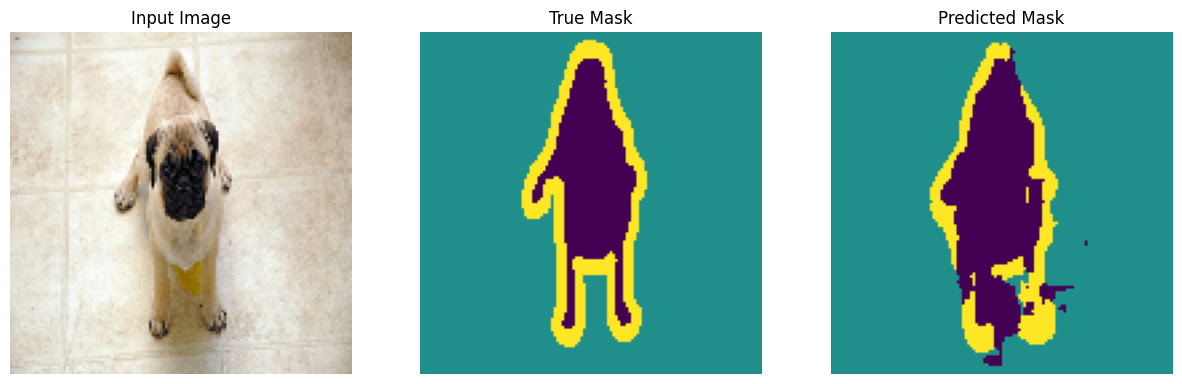

2/2 [==============================] - 0s 102ms/step


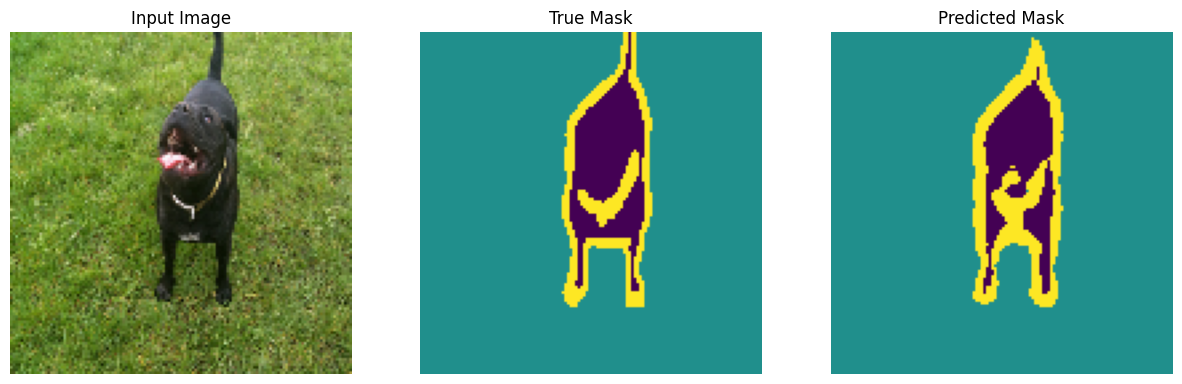

2/2 [==============================] - 0s 92ms/step


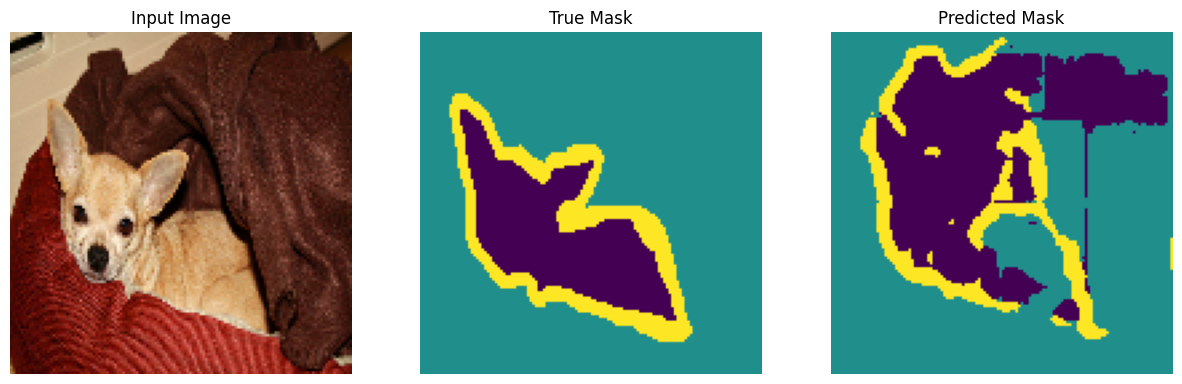

2/2 [==============================] - 0s 97ms/step


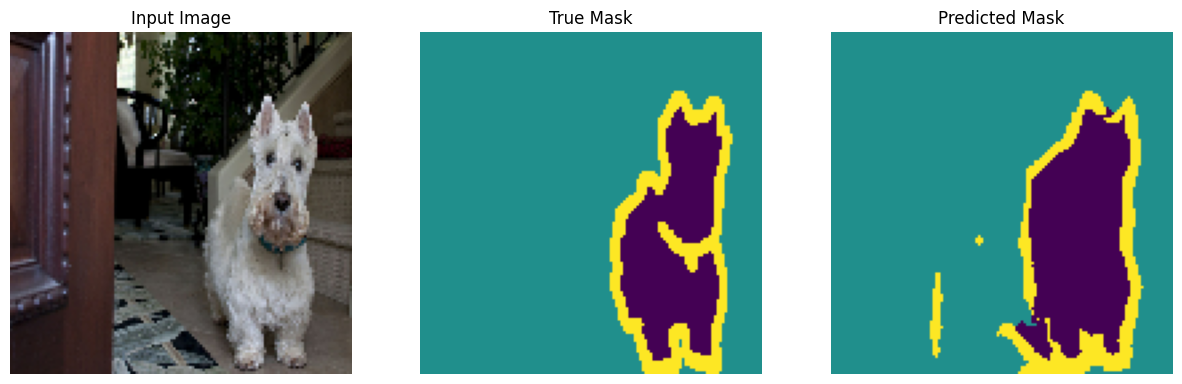

2/2 [==============================] - 0s 91ms/step


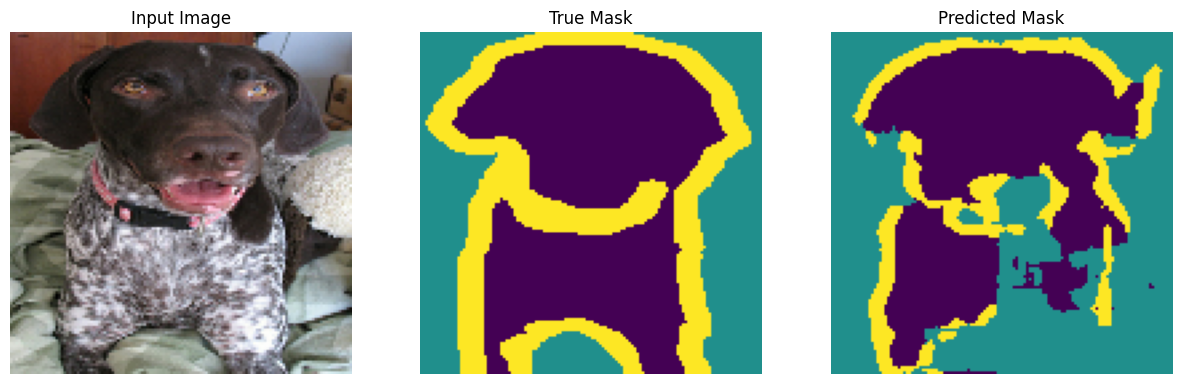

In [34]:
show_predictions(test_batches, 10)